In [8]:
import numpy as np
import seaborn
from scipy import stats
import csv
import pandas as pd
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import re

# Hamming weight calculator
def hw(int_no):
    count = 0
    while(int_no):
        int_no &= (int_no-1)
        count += 1
    return count

Sbox = (
    0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
    0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
    0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
    0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
    0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
    0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
    0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
    0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
    0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
    0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
    0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
    0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
    0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
    0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
    0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
    0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16,
)

In [9]:
df_all       = pd.read_csv('waveform.csv', header=None)
plaintexts   = df_all.iloc[:, 0]                # still the 32‑hex‑digit strings
samples_df   = df_all.drop(columns=[0, 1])      # drop plaintext (0) & ciphertext (1)
samples_df   = samples_df.dropna(axis=1, how='all')

In [10]:
# Safe byte extraction
def extract_plaintext_bytes(hexstr):
    pairs = re.findall(r'(?:0x)?([0-9A-Fa-f]{2})', str(hexstr))
    if not pairs:
        raise ValueError(f"Could not parse any hex bytes from '{hexstr}'")
    return [int(p, 16) for p in pairs]
# Hamming‐weight, S‑box, extract_plaintext_bytes stay the same

num_traces, num_samples = samples_df.shape
sample_cols = samples_df.columns.tolist()

def build_power_model(byte_index):
    models = np.zeros((256, num_traces), dtype=float)
    for k in range(256):
        for i in range(num_traces):
            pt_bytes    = extract_plaintext_bytes(plaintexts.iat[i])
            pt          = pt_bytes[byte_index]
            models[k, i] = hw(Sbox[pt ^ k])
    return models

def build_correlation_matrix(models):
    corr_mat = np.zeros((256, num_samples), dtype=float)
    for k in range(256):
        model_trace = models[k, :]
        for idx, col in enumerate(sample_cols):
            trace_vals = samples_df[col].values
            corr_mat[k, idx] = abs(pearsonr(model_trace, trace_vals)[0])
    return corr_mat


# Plot and recover
def plot_key_ranking(corr_mat):
    max_corrs = corr_mat.max(axis=1)
    plt.figure(figsize=(12, 6))
    plt.plot(range(256), max_corrs, marker='.', linestyle='-')
    best = int(np.argmax(max_corrs))
    plt.axvline(best, color='r', linestyle='--',
                label=f'Best guess: 0x{best:02X}')
    plt.xlabel('Key guess (0x00–0xFF)')
    plt.ylabel('Max |PearsonR|')
    plt.legend(); plt.grid(True); plt.show()
    return best





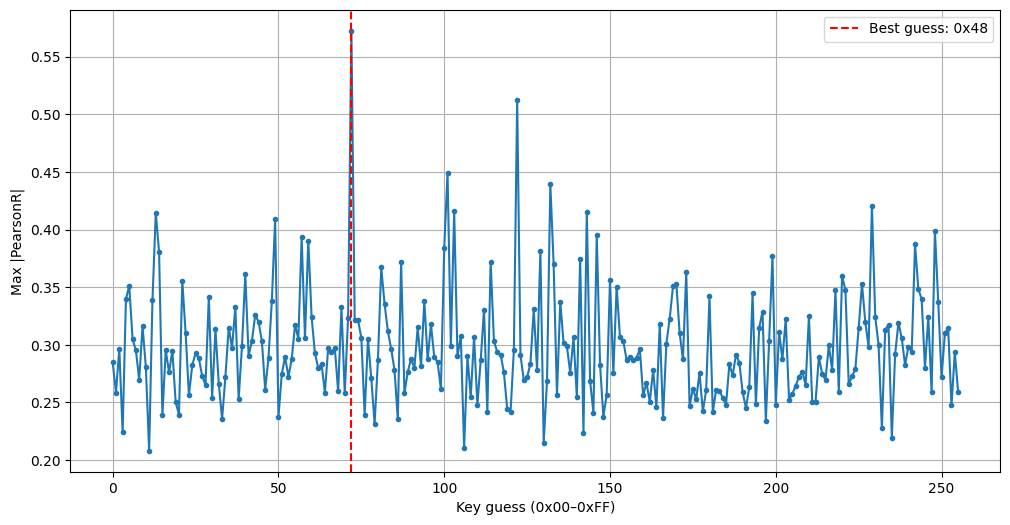

Recovered key byte: 0x48


In [11]:
# Execute CPA on byte 0
models          = build_power_model(0)
corr_matrix     = build_correlation_matrix(models)
recovered_byte  = plot_key_ranking(corr_matrix)
print(f"Recovered key byte: 0x{recovered_byte:02X}")

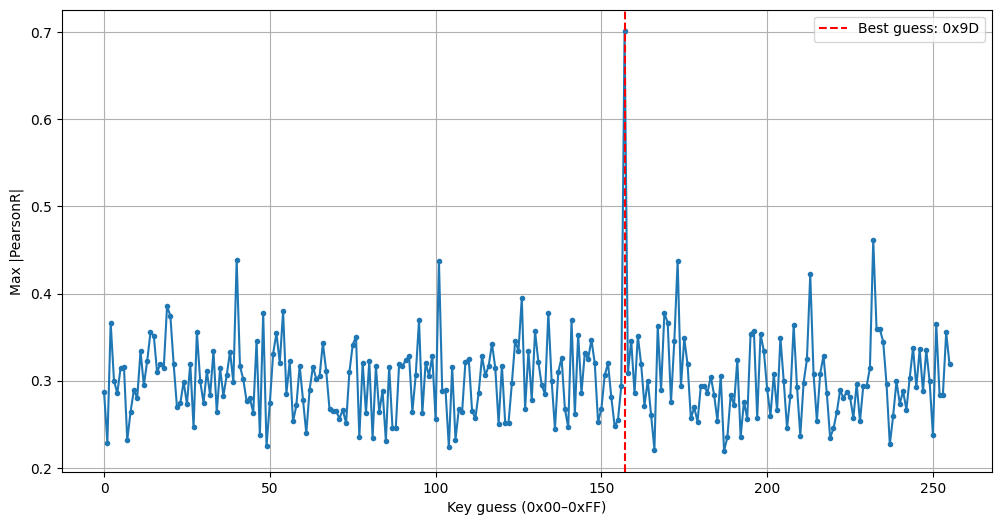

Recovered key byte: 0x9D


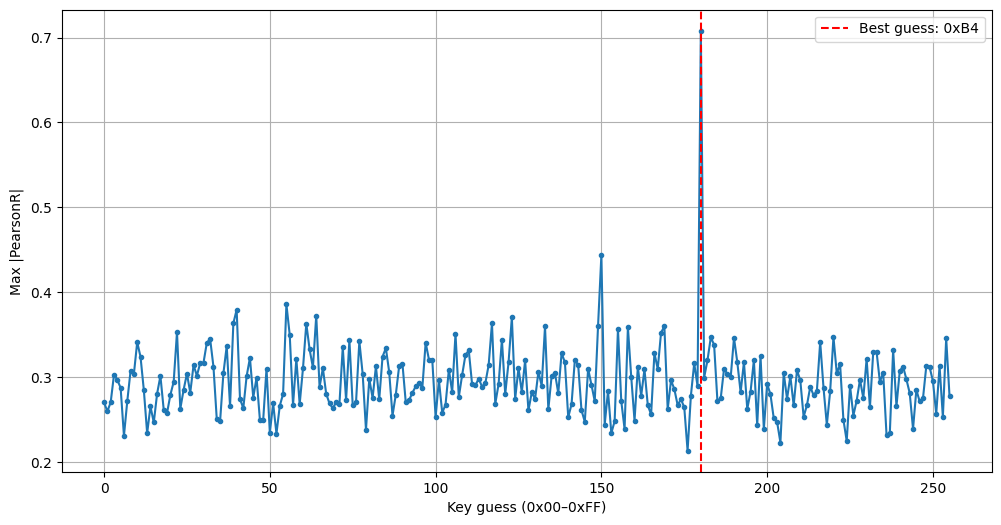

Recovered key byte: 0xB4


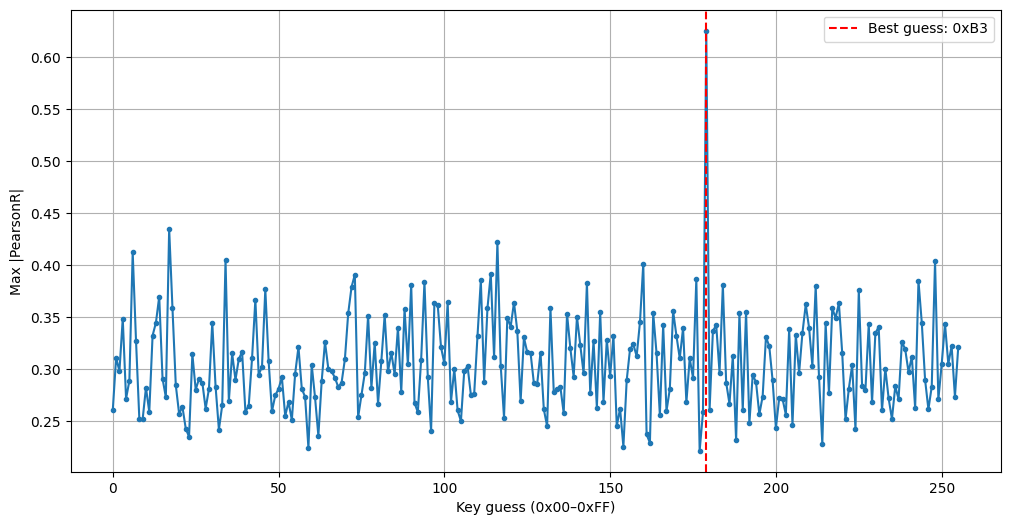

Recovered key byte: 0xB3


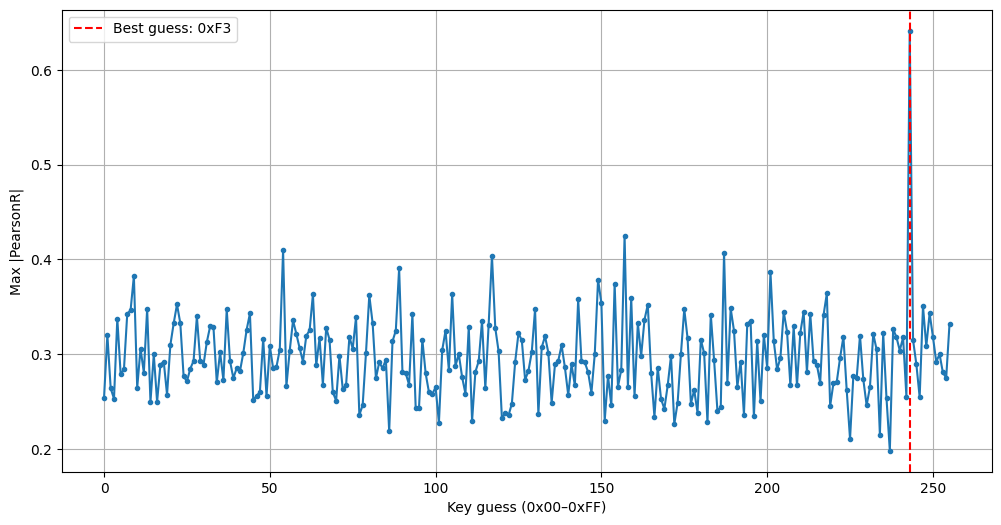

Recovered key byte: 0xF3


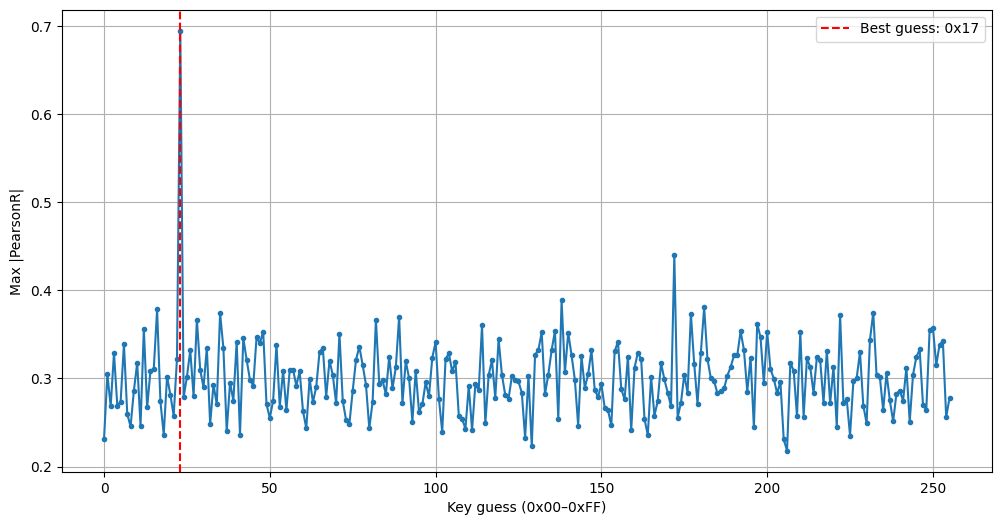

Recovered key byte: 0x17


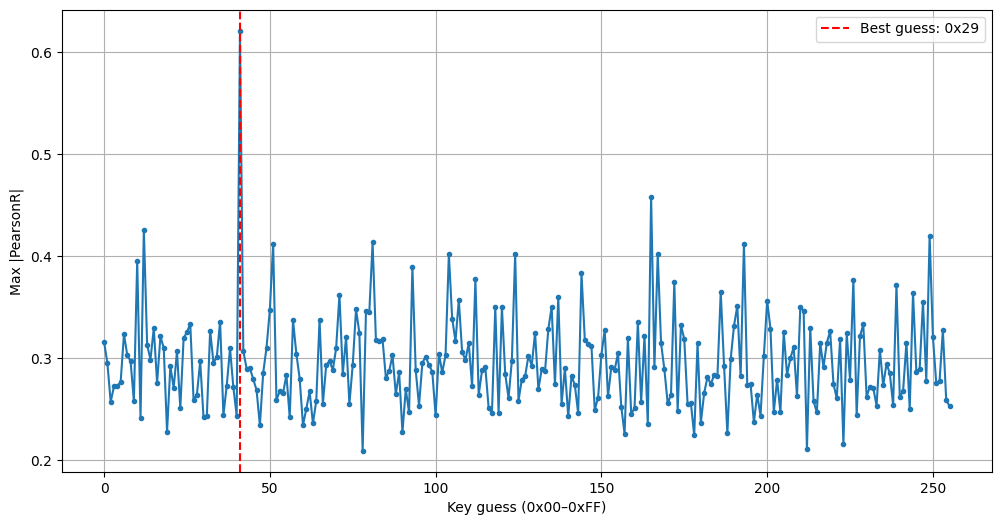

Recovered key byte: 0x29


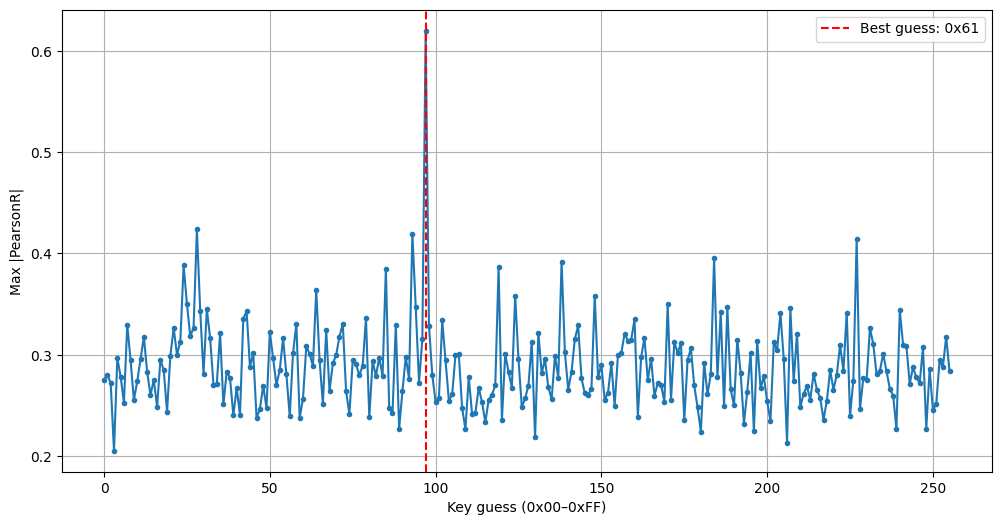

Recovered key byte: 0x61


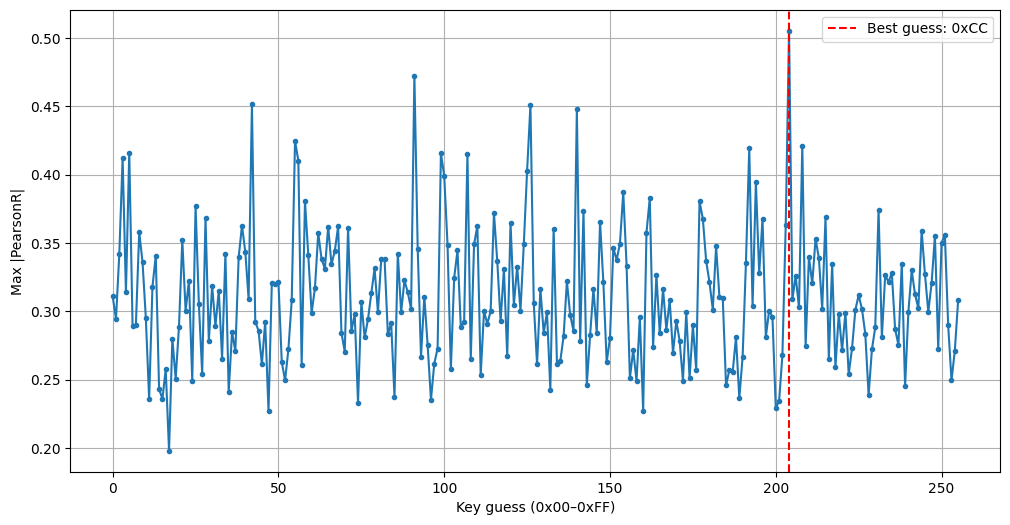

Recovered key byte: 0xCC


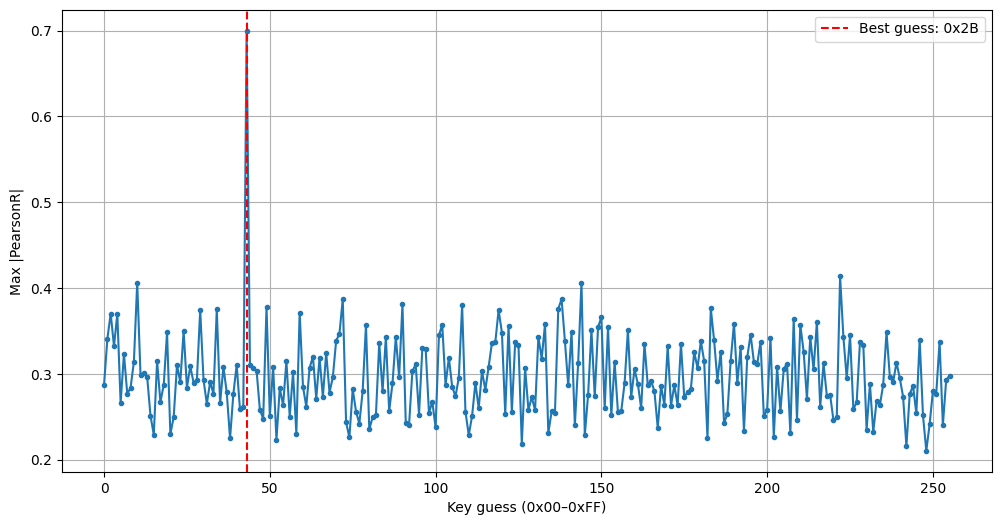

Recovered key byte: 0x2B


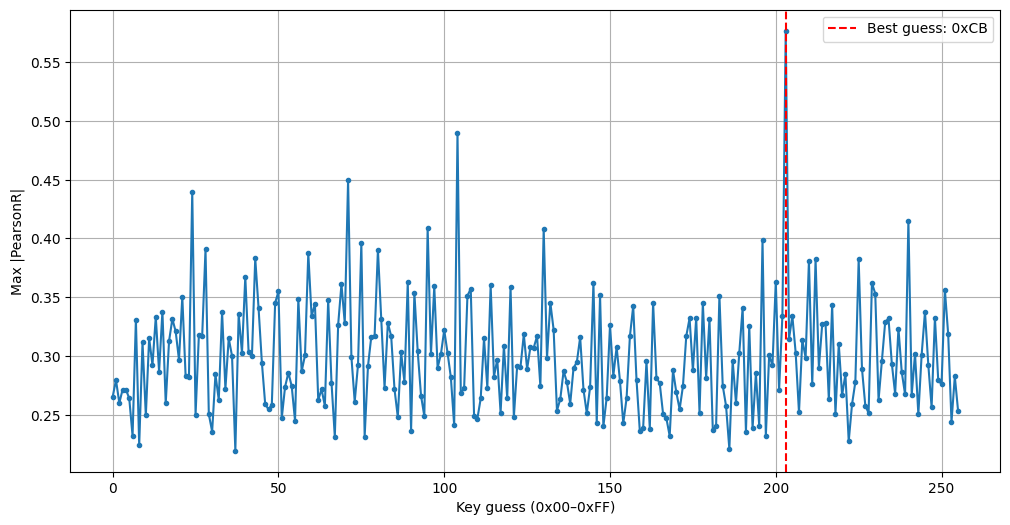

Recovered key byte: 0xCB


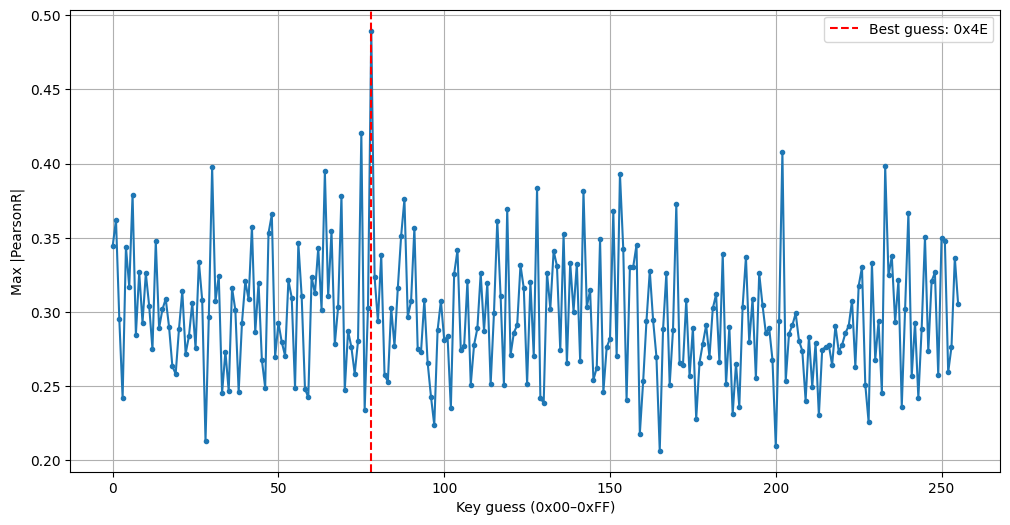

Recovered key byte: 0x4E


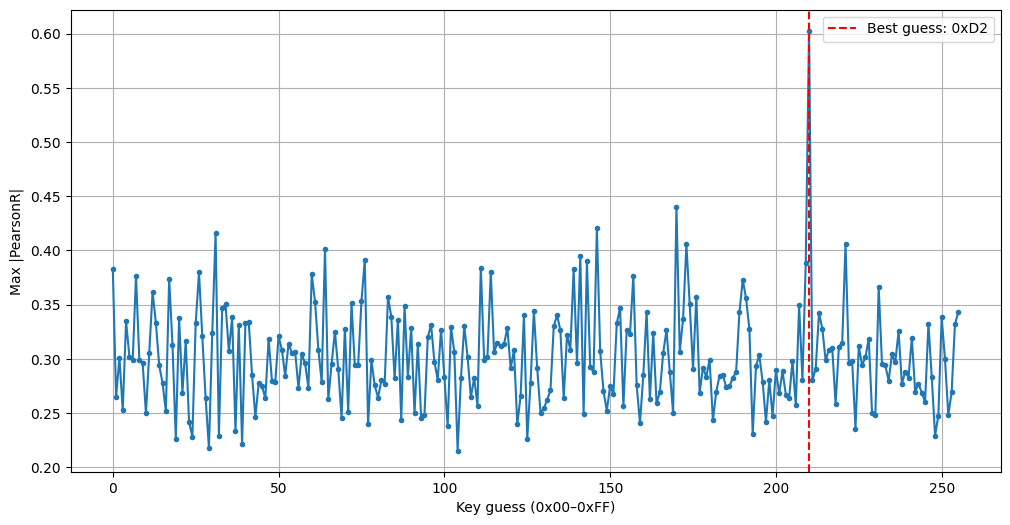

Recovered key byte: 0xD2


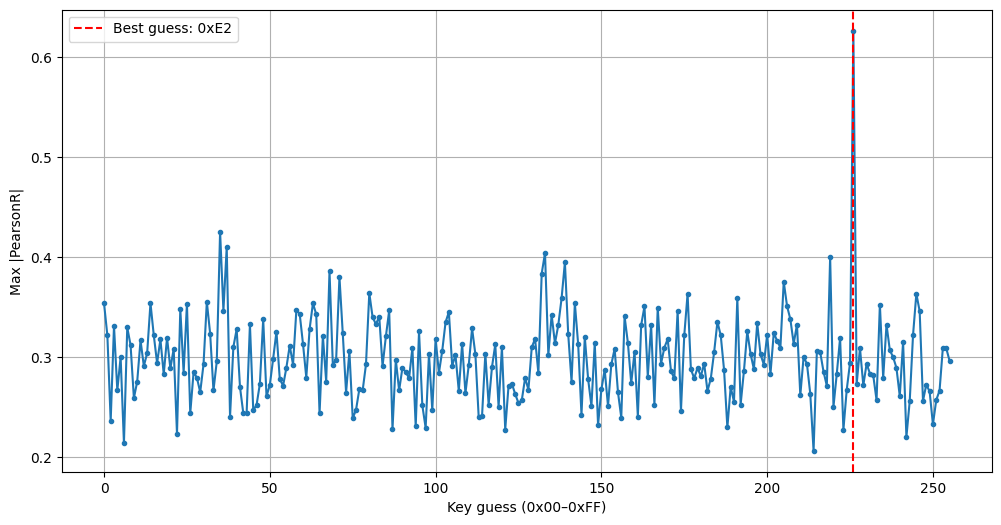

Recovered key byte: 0xE2


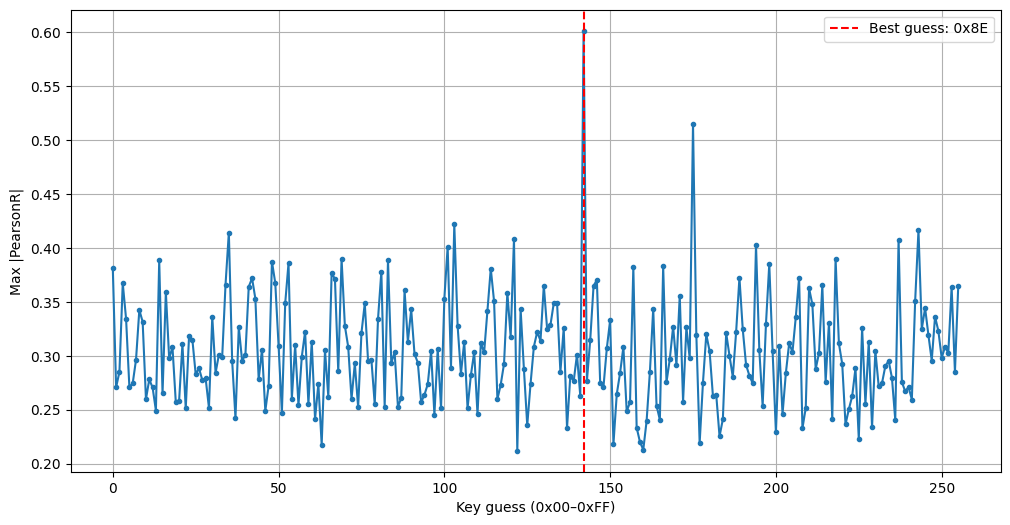

Recovered key byte: 0x8E


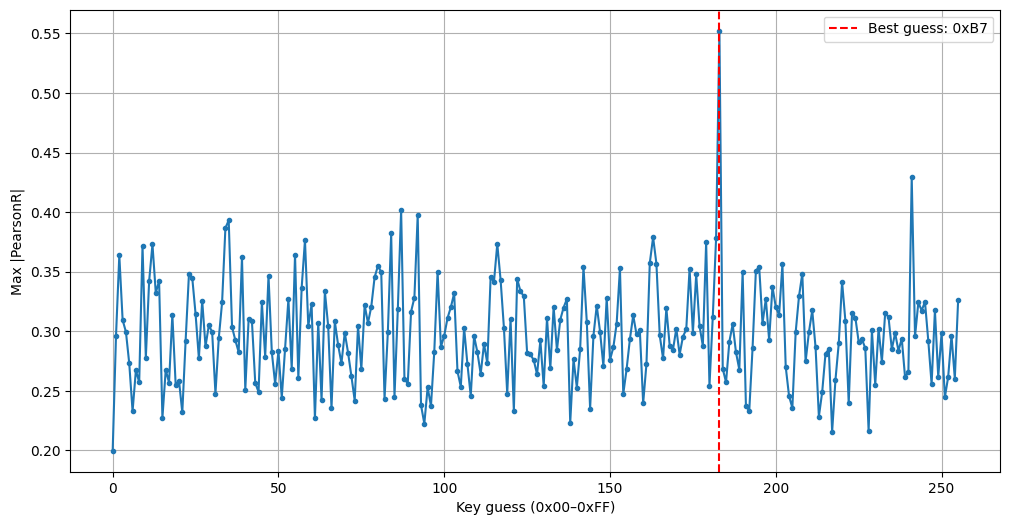

Recovered key byte: 0xB7


In [12]:
recovered = []
recovered.append(recovered_byte)
for i in range(1,16):
    model                   = build_power_model(i)
    corr                    = build_correlation_matrix(model)
    recovered_byte_iter      = plot_key_ranking(corr)
    recovered.append(recovered_byte_iter)
    print(f"Recovered key byte: 0x{recovered_byte_iter:02X}")

In [ ]:
key = ""
for byte in recovered:
    key += f"{byte:02x}"  # Format each byte as a 2-digit hexadecimal
print(key)


721571801792432341972044320378210226142183


In [ ]:
print(recovered)

[72, 157, 180, 179, 243, 23, 41, 97, 204, 43, 203, 78, 210, 226, 142, 183]
